# setup

In [ ]:
import torch, os
import torch.nn as nn
import pandas as pd

esm_name_dct = {
     'esm1b': 'esm1b_t33_650M_UR50S',
     'esm1v_1': 'esm1v_t33_650M_UR90S_1',
     'esm1v_2': 'esm1v_t33_650M_UR90S_2',
     'esm1v_3': 'esm1v_t33_650M_UR90S_3',
     'esm1v_4': 'esm1v_t33_650M_UR90S_4',
     'esm1v_5': 'esm1v_t33_650M_UR90S_5',
     'esm2_650m': 'esm2_t33_650M_UR50D',
     'esm2_3b': 'esm2_t36_3B_UR50D',
     'esm2_150m': 'esm2_t30_150M_UR50D',
     'esm2_8m': 'esm2_t6_8M_UR50D',
     'esm2_35m': 'esm2_t12_35M_UR50D',
     'esm2_15b': 'esm2_t48_15B_UR50D'
 }

device='cuda:0'

from transformers import AutoTokenizer, EsmForMaskedLM
def load_esm_model(model_name, pretrained=True):
    checkpoint = f'facebook/{model_name}' if pretrained else model_name
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    model = EsmForMaskedLM.from_pretrained(checkpoint)
    return model, tokenizer

def load_model(model_name):
    model, tokenizer = load_esm_model(esm_name_dct[model_name])
    return model, tokenizer

In [ ]:
### utils
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import torch
import torch.nn as nn
from torch.optim import Adam, AdamW
from transformers import get_linear_schedule_with_warmup
from transformers import AutoTokenizer, EsmForMaskedLM, EsmPreTrainedModel, EsmConfig
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

AAorder=['K','R','H','E','D','N','Q','T','S','C','G','A','V','L','I','M','P','Y','F','W']
AAorder2idx = {j:i for i,j in enumerate(AAorder)}

def get_LLR(sequence,esm_model):
  tokens = tokenizer(sequence, truncation=False, padding='do_not_pad', return_tensors='pt')
  batch_tokens = tokens['input_ids']
  attention_mask = tokens['attention_mask']
  esm_model.eval()
  with torch.no_grad():
    logits =torch.log_softmax(esm_model(batch_tokens.to(device),attention_mask = attention_mask.to(device))['logits'],dim=-1)[0,:,:].cpu()
  tok = batch_tokens[0,:].cpu()
  wt_norm = logits[np.arange(len(tok)), tok].unsqueeze(1)
  LLR = logits - wt_norm
  LLR=LLR[1:-1,4:24].numpy()
  AAorder=['K','R','H','E','D','N','Q','T','S','C','G','A','V','L','I','M','P','Y','F','W']
  LLR_ = pd.DataFrame(LLR,columns=tokenizer.all_tokens[4:24],index=list(sequence)).T.loc[AAorder]
  LLR_.columns = [j.split('.')[0]+' '+str(i+1) for i,j in enumerate(LLR_.columns)]
  return LLR_

def get_DMS_matrix(df,seq,pos_column,mut_aa_column,value_column, fillna = np.nan):
  X_data = fillna*np.ones((len(AAorder),len(seq)))
  for pos,aa,val in zip(df[pos_column].astype(int),df[mut_aa_column],df[value_column]):
    if aa in AAorder2idx.keys():
      X_data[AAorder2idx[aa],pos-1] = val
  return X_data

def DMS2LLR_params(X_data,mask,LLR):
  dms = X_data[mask]
  llr = LLR.values[mask]
  sign=np.sign(spearmanr(dms,llr)[0])
  dms_mean=np.mean(dms)
  dms_std = np.std(dms)
  llr_mean=np.mean(llr)
  llr_std=np.std(llr)
  return {
      'sign':sign,
      'dms_mean':dms_mean,
      'dms_std':dms_std,
      'llr_mean':llr_mean,
      'llr_std':llr_std
  }

def DMS2LLR(X_data,params):
  return ((params['sign']*(X_data - params['dms_mean'])/params['dms_std'])*params['llr_std']) + params['llr_mean']

In [ ]:
def train_test_split(X, train_frac=0.15, valid_frac=0.05):
    # Ensure fractions are valid
    if train_frac + valid_frac > 1:
        raise ValueError("train_frac and valid_frac must sum to 1 or less.")

    # Initialize empty matrices for train, valid, and test
    X_train = np.zeros_like(X)
    X_valid = np.zeros_like(X)
    X_test = np.zeros_like(X)

    # Find valid (non-NaN) indices
    valid_indices = np.where(~np.isnan(X))
    num_valid_elements = len(valid_indices[0])

    # Determine the number of elements for training, validation, and testing
    train_elements = int(num_valid_elements * train_frac)
    valid_elements = int(num_valid_elements * valid_frac)
    test_elements = num_valid_elements - train_elements - valid_elements

    # Flatten valid indices for easier handling and shuffle them
    flat_valid_indices = np.ravel_multi_index(valid_indices, X.shape)
    np.random.shuffle(flat_valid_indices)

    # Assign indices to train, valid, and test
    train_indices = flat_valid_indices[:train_elements]
    valid_indices = flat_valid_indices[train_elements:train_elements + valid_elements]
    test_indices = flat_valid_indices[train_elements + valid_elements:]

    # Fill train, valid, and test matrices with 1s at the respective indices
    X_train.flat[train_indices] = 1
    X_valid.flat[valid_indices] = 1
    X_test.flat[test_indices] = 1

    return X_train.astype(bool), X_valid.astype(bool), X_test.astype(bool)


import numpy as np

def train_test_split_columnwise(X, N, N_v,verbose=True):
    # Ensure N and N_v are non-negative integers
    if not (isinstance(N, int) and N >= 0):
        raise ValueError("N must be a non-negative integer.")
    if not (isinstance(N_v, int) and N_v >= 0):
        raise ValueError("N_v must be a non-negative integer.")

    # Initialize masks with False
    X_train = np.zeros_like(X, dtype=bool)
    X_valid = np.zeros_like(X, dtype=bool)
    X_test = np.zeros_like(X, dtype=bool)

    num_rows, num_cols = X.shape

    for col in range(num_cols):
        # Get non-NaN indices for the current column
        non_nan_mask = ~np.isnan(X[:, col])
        non_nan_indices = np.where(non_nan_mask)[0]
        total_non_nan = len(non_nan_indices)

        # Check if there are enough non-NaN entries
        if total_non_nan < N + N_v:
            if verbose:
              print(f"Position {col+1} has {total_non_nan} non-NaN variants, which is less than N + N_v = {N + N_v}. Skipping.")
        else:
          # Shuffle the non-NaN indices
          shuffled_indices = np.random.permutation(non_nan_indices)

          # Split into train, valid, test
          train_indices = shuffled_indices[:N]
          valid_indices = shuffled_indices[N:N + N_v]
          test_indices = shuffled_indices[N + N_v:]

          # Assign the indices to the respective masks
          X_train[train_indices, col] = True
          X_valid[valid_indices, col] = True
          X_test[test_indices, col] = True

    return X_train, X_valid, X_test

def get_batch(X,mask,seq,tokenizer,):

  wt_tokens = tokenizer(seq, return_tensors='pt')
  wt_input_ids = wt_tokens['input_ids']
  attention_masks = wt_tokens['attention_mask']

  X_target = X.copy()
  X_target[np.isnan(X_target)] = 0

  X_target = np.hstack([100*np.ones((X_target.shape[0],1)), X_target,100*np.ones((X_target.shape[0],1))])
  X_target=np.transpose(X_target, (1, 0))

  X_target_mask = mask.astype(int).copy()
  X_target_mask = np.hstack([np.zeros((X_target_mask.shape[0],1)), X_target_mask,np.zeros((X_target_mask.shape[0],1))])
  X_target_mask=np.transpose(X_target_mask, (1, 0))

  batch = {"wt": wt_input_ids, "attention_mask": attention_masks, "X_target": torch.tensor(X_target).float().unsqueeze(0),"X_target_mask":torch.tensor(X_target_mask).long().unsqueeze(0)}
  return batch

##############################
criterion = torch.nn.MSELoss(size_average=None, reduce=None, reduction='none')

def get_mse_loss_batch_G(model, batch):
    vocabs = tokenizer.get_vocab()
    indices = [vocabs[v] for v in AAorder]

    input_ids = batch['wt'].to(device)
    target_llrs = batch['X_target'][:, :input_ids.shape[1]].to(device)
    attention_mask = batch['attention_mask'].to(device)

    X_target_mask = batch['X_target_mask'].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    token_probs = torch.log_softmax(outputs["logits"],dim=-1)
    wt_norm = token_probs * F.one_hot(input_ids, num_classes=33)
    wt_norm = wt_norm.sum(dim=-1, keepdim=True)
    permuted_probs = token_probs[:, :, indices]
    model_llrs=permuted_probs - wt_norm.expand(permuted_probs.shape)

    model_llrs=model_llrs*X_target_mask
    target_llrs=target_llrs*X_target_mask

    losses = criterion(model_llrs, target_llrs)

    pos_lens = X_target_mask.sum(dim=-1).sum(dim=1)
    losses = losses.mean(dim=-1)
    # print(losses,pos_lens.sum())
    loss = losses.sum() / pos_lens.sum()
    return loss

def setup_model_optimizer(model,lr,warmup_rate,weight_decay,nepochs,N_LAST_LAYERS,verbose=False):

  #########################
  model_params = []
  for name, param in model.named_parameters():
        param.requires_grad = False
  for name, param in model.lm_head.named_parameters():
        param.requires_grad = True

  last_layer_parameters=[]
  for layer in range(N_LAST_LAYERS):
    for name, param in model.esm.encoder.layer[-1-layer].named_parameters():
          param.requires_grad = True
    last_layer_parameters += list(model.esm.encoder.layer[-1-layer].parameters())

  head_parameters = model.lm_head.parameters()

  model_params += list(head_parameters) + list(last_layer_parameters)

  # model_params=list(model.parameters())
  optim = AdamW(model_params , lr=lr, weight_decay=weight_decay)

  total_steps = nepochs
  warmup_rate = warmup_rate
  warmup_steps = int(total_steps * warmup_rate)
  scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

  if verbose: print(f'Total number of esm parameters: {np.round(sum(p.numel() for p in model_params if p.requires_grad)/1e6,2)}M')

  return optim,scheduler


def train_model(model,optim,scheduler,batch,all_data,train_mask,valid_mask,nepochs, early_stop=True, wait_epochs=100,verbose=True):
  model.train()  # Set the model to training mode.
  best=-1000
  train_spearman=[]
  valid_spearman=[]
  for epoch in range(nepochs):
            optim.zero_grad()
            loss = get_mse_loss_batch_G(model, batch)
            loss.backward()
            optim.step()
            scheduler.step()
            if epoch % 10 == 1:
              with torch.no_grad():
                LLR = get_LLR(seq,model)
                train_spearman+=[spearmanr(all_data[train_mask],LLR.values[train_mask])[0]]
                valid_spearman+=[spearmanr(all_data[valid_mask],LLR.values[valid_mask])[0]]
                if verbose:
                  print(f"{epoch},loss={get_mse_loss_batch_G(model,batch).item():.3f}, train:{train_spearman[-1]:.3f},'valid:'{valid_spearman[-1]:.3f},")

                if early_stop and (epoch>wait_epochs):
                  if valid_spearman[-1]>best:
                    best=valid_spearman[-1]
                  else:
                    break

  if verbose: print(f'loss={get_mse_loss_batch_G(model,batch).item()}')
  model.eval()
  return {'train_spearman':train_spearman,'valid_spearman':valid_spearman}

def meltLLR(LLR):
  mmm = LLR.melt(ignore_index=False).reset_index()
  mmm['mut'] = mmm['variable'].str[0]+mmm['variable'].str[2:] + mmm['index']
  del mmm['index'], mmm['variable']
  mmm = mmm.rename(columns={'value':'LLR'})
  return mmm[['mut','LLR']].set_index('mut').LLR

def mask2mut(mask,index,columns):
  tmp = pd.DataFrame(mask,index=index,columns=columns)
  mmm = tmp.melt(ignore_index=False).reset_index()
  mmm['mut'] = mmm['variable'].str[0]+mmm['variable'].str[2:] + mmm['index']
  del mmm['index'], mmm['variable']
  mmm = mmm[['mut','value']].copy()
  return list(mmm[mmm.value==1].mut)

# run experiment

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import torch
from sklearn.linear_model import Ridge

def run_experiment(df, seq, encoded_sequences, assay, N_train, iteration, N_LAST_LAYERS = 3,
                   model_name='esm1b', max_optim_steps = 300, device='cuda', N_valid=1, K=10, verbose=False):
    # Set seeds for reproducibility
    seed = iteration
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Load data matrix
    X_dms = get_DMS_matrix(df, seq, 'pos', 'var_aa', assay)

    # Split data
    train_mask, valid_mask, test_mask = train_test_split_columnwise(
        X_dms, N=N_train, N_v=N_valid, verbose=verbose
    )

    # Load model
    model, tokenizer = load_model(model_name)
    model = model.eval().to(device)

    # Baseline evaluation
    with torch.no_grad():
        LLR = get_LLR(seq, model)

    # Fine-tuning setup
    DMS_params = DMS2LLR_params(X_dms, (train_mask+valid_mask).astype(bool), LLR)
    X_s = DMS2LLR(X_dms, DMS_params)

    # Model training
    optim, scheduler = setup_model_optimizer(
        model, lr=1e-5, warmup_rate=1e-3,
        weight_decay=0.01, nepochs=max_optim_steps, N_LAST_LAYERS=N_LAST_LAYERS
    )
    batch = get_batch(X_s,train_mask,seq,tokenizer,)
    _ = train_model(model,optim,scheduler,batch, X_s, train_mask, valid_mask, nepochs=max_optim_steps, verbose=verbose, wait_epochs=30)

    # Get final predictions
    with torch.no_grad():
        LLR_ft = get_LLR(seq, model)

    # Prepare for regression models
    df['tmp_score'] = df.full_var.map(meltLLR(LLR_ft))
    X_base = encoded_sequences
    y = df[assay].values

    # Get split indices
    train_muts = mask2mut((train_mask+valid_mask).astype(bool), LLR_ft.index, LLR_ft.columns)
    train_mask = df.full_var.isin(train_muts)
    test_mask = ~train_mask
    train_idx = np.where(train_mask)[0]  # Positional indices
    test_idx = np.where(test_mask)[0]

    # Initialize prediction storage
    predictions = {
        f'FT-LL{N_LAST_LAYERS}': df.loc[test_mask, 'tmp_score'].values,
        f'FTR-LL{N_LAST_LAYERS}': None,
        'OHE_esm': None,
        'OHE_am': None
    }

    # Ridge Regression models
    for method, feat in [(f'FTR-LL{N_LAST_LAYERS}', 'tmp_score'),
                        ('OHE_esm', 'ESM1b_score'),
                        ('OHE_am', 'am_pathogenicity')]:
        X = np.hstack([X_base, df[feat].values.reshape(-1,1)])
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        ridge = Ridge().fit(X_train, y_train)
        predictions[method] = ridge.predict(X_test)

    # Store predictions in dataframe
    for method, preds in predictions.items():
        col_name = f'pred_{assay}:N{N_train+N_valid}:iter{iteration}:{method}'
        df.loc[test_mask, col_name] = preds

    ##### print results ####

    # Calculate Spearman correlations
    spearman_results = {}
    for method in predictions.keys():
        col_name = f'pred_{assay}:N{N_train+N_valid}:iter{iteration}:{method}'
        spearman_results[method] = spearmanr(df.loc[test_mask, assay],
                                            df.loc[test_mask, col_name])[0]

    # Sort results from best to worst
    sorted_results = sorted(spearman_results.items(),
                            key=lambda x: abs(x[1]),
                            reverse=True)

    # Print results
    print(f"\nSpearman Correlations for {assay} (N={N_train+N_valid}, iter={iteration}):")
    for method, corr in sorted_results:
        print(f"{method}: {abs(corr):.3f}")

    return df

## P2RY8

In [ ]:
seq = 'MQVPNSTGPDNATLQMLRNPAIAVALPVVYSLVAAVSIPGNLFSLWVLCRRMGPRSPSVIFMINLSVTDLMLASVLPFQIYYHCNRHHWVFGVLLCNVVTVAFYANMYSSILTMTCISVERFLGVLYPLSSKRWRRRRYAVAACAGTWLLLLTALSPLARTDLTYPVHALGIITCFDVLKWTMLPSVAMWAVFLFTIFILLFLIPFVITVACYTATILKLLRTEEAHGREQRRRAVGLAAVVLLAFVTCFAPNNFVLLAHIVSRLFYGKSYYHVYKLTLCLSCLNNCLDPFVYYFASREFQLRLREYLGCRRVPRDTLDTRRESLFSARTTSVRSEAGAHPEGMEGATRPGLQRQESVF'
df = pd.read_csv('/data/P2RY8_DMS_AM_ESM.csv')
df = df[df.full_var.str[0] != df.full_var.str[-1]].copy() #remove WT


from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from scipy.stats import spearmanr

## OneHot Encoding
unique_amino_acids = sorted(set([aa for seq in df['full_var_seq'] for aa in seq]))
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(np.array(unique_amino_acids).reshape(-1, 1))

# Encode sequences
encoded_sequences = [
    encoder.transform(np.array(list(seq)).reshape(-1, 1)).reshape(-1,1)
    for seq in df['full_var_seq']
]
encoded_sequences=np.hstack(encoded_sequences).T


In [ ]:
model_name  = 'esm1b'
model, tokenizer = load_model(model_name)
model = model.eval().to(device)
# -----------------------------------------------------------
K = 50
N_train_values = [1,2,4,6,8,10]
N_valid = 1
assays = ['Expr_z_score', 'Migr_z_score', 'Prolif_z_score']

for assay in assays:
    for N_train in N_train_values:
        for iteration in range(K):
            # print(f'Running {assay} < N={N_train+N_valid} > Iteration {iteration}')
            df = run_experiment(df, seq, encoded_sequences, assay, N_train, iteration, model_name=model_name,N_valid=N_valid, max_optim_steps=300)
            if iteration % 20 == 0:
                df = df.copy()

df.to_csv('P2RY8_all_results.csv.gz')

# plots

In [ ]:
import pandas as pd

df = pd.read_csv('P2RY8_all_results.csv.gz')

## get results

In [ ]:
import pandas as pd
from scipy.stats import spearmanr

# Initialize a list to store results
results = []

# Loop through all prediction columns in df
for col in df.columns:
    if col.startswith('pred_'):
        # Parse column name to extract metadata
        parts = col.split(':')
        assay = parts[0].replace('pred_', '')
        N_train = int(parts[1].replace('N', ''))
        iteration = int(parts[2].replace('iter', ''))
        method = '_'.join(parts[3:])

        # Get true values and predictions
        true_values = df[assay]
        predictions = df[col]

        # Filter out NaN values (test set only)
        mask = ~predictions.isna()
        true_values_filtered = true_values[mask]
        predictions_filtered = predictions[mask]

        # Compute Spearman correlation
        spearman_corr, _ = spearmanr(true_values_filtered, predictions_filtered)

        # Store results
        results.append({
            'assay': assay,
            'N_train': N_train,
            'iteration': iteration,
            'method': method,
            'spearman_corr': abs(spearman_corr)
        })
        # This needs to happen only once per iteration, hence the if statement (choice of OHE_esm is arbitrary)
        if method == 'OHE_esm':
          method='esm1b_base'
          predictions = df['ESM1b_score']
          true_values_filtered = true_values[mask]
          predictions_filtered = predictions[mask]
          spearman_corr, _ = spearmanr(true_values_filtered, predictions_filtered)
          results.append({
            'assay': assay,
            'N_train': N_train,
            'iteration': iteration,
            'method': method,
            'spearman_corr': abs(spearman_corr)
          })

          method='AM_base'
          predictions = df['am_pathogenicity']
          true_values_filtered = true_values[mask]
          predictions_filtered = predictions[mask]
          spearman_corr, _ = spearmanr(true_values_filtered, predictions_filtered)
          results.append({
            'assay': assay,
            'N_train': N_train,
            'iteration': iteration,
            'method': method,
            'spearman_corr': abs(spearman_corr)
          })

results_df = pd.DataFrame(results)

# # Save results to CSV
results_df.to_csv('P2RY8_all_results_spearman_corrs.csv.gz')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

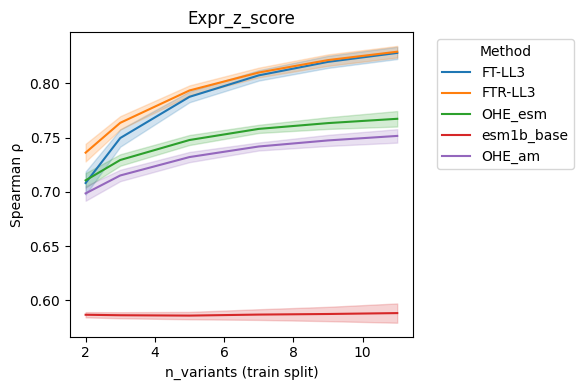

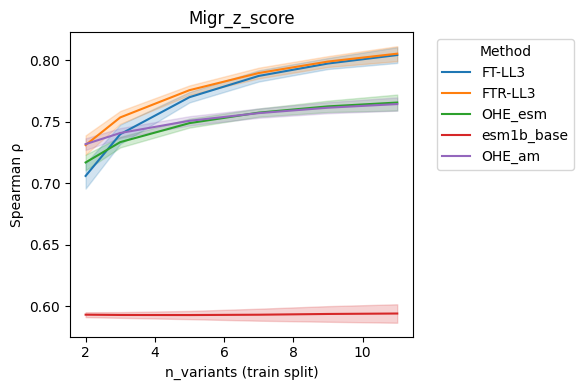

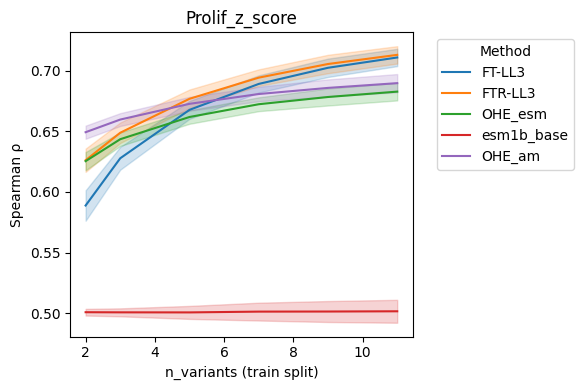

In [ ]:
# List of assays
assays = ['Expr_z_score', 'Migr_z_score', 'Prolif_z_score']

# Iterate over each assay
for assay in assays:
    # Filter for the specific assay and exclude methods ['AM_base', 'FT']
    res = results_df[(results_df.assay == assay) & (~results_df.method.isin(['AM_base']))]
    plt.figure(figsize=(6,4))
    # Create line plot
    sns.lineplot(data=res, x='N_train', y='spearman_corr', hue='method', errorbar='sd')

    # Set plot labels and title
    plt.ylabel('Spearman ρ')
    plt.title(assay)
    plt.xlabel('n_variants (train split)')

    # Move legend outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Method')

    # Show the plot
    plt.tight_layout()  # Adjust layout to accommodate legend
    plt.show()


# extrapolation

In [ ]:
### Train on P2RY8 ###
seq = 'MQVPNSTGPDNATLQMLRNPAIAVALPVVYSLVAAVSIPGNLFSLWVLCRRMGPRSPSVIFMINLSVTDLMLASVLPFQIYYHCNRHHWVFGVLLCNVVTVAFYANMYSSILTMTCISVERFLGVLYPLSSKRWRRRRYAVAACAGTWLLLLTALSPLARTDLTYPVHALGIITCFDVLKWTMLPSVAMWAVFLFTIFILLFLIPFVITVACYTATILKLLRTEEAHGREQRRRAVGLAAVVLLAFVTCFAPNNFVLLAHIVSRLFYGKSYYHVYKLTLCLSCLNNCLDPFVYYFASREFQLRLREYLGCRRVPRDTLDTRRESLFSARTTSVRSEAGAHPEGMEGATRPGLQRQESVF'
df = pd.read_csv('/data/P2RY8_DMS_AM_ESM.csv')
df = df[df.full_var.str[0] != df.full_var.str[-1]].copy() #remove WT

In [ ]:
model_name = 'esm1b'
model, tokenizer = load_model(model_name)
model=model.eval().to(device)

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
N_train = 10
N_valid = 19-N_train
max_optim_steps = 50

assay = 'Expr_z_score'
X_dms = get_DMS_matrix(df, seq, 'pos', 'var_aa', assay)

# Split data
train_mask, valid_mask, test_mask = train_test_split_columnwise(
    X_dms, N=N_train, N_v=N_valid, verbose=False
)

# Baseline evaluation
with torch.no_grad():
    LLR = get_LLR(seq, model)
    test_spearman_base = abs(spearmanr(X_dms[test_mask], LLR.values[test_mask])[0])


df['esm_base_score'] = df.full_var.map(meltLLR(LLR))

DMS_params = DMS2LLR_params(X_dms, (train_mask+valid_mask).astype(bool), LLR)
X_s = DMS2LLR(X_dms, DMS_params)

# Train

optim, scheduler = setup_model_optimizer(
    model, lr=1e-5, warmup_rate=1e-3,
    weight_decay=0.01, nepochs=max_optim_steps, N_LAST_LAYERS=3
)

batch = get_batch(X_s,train_mask,seq,tokenizer,)
_ = train_model(model,optim,scheduler,batch, X_s, train_mask, valid_mask, nepochs=max_optim_steps, verbose=False, wait_epochs=30)

# Get final predictions
with torch.no_grad():
    LLR_ft = get_LLR(seq, model)

df['esm_ft_score'] = df.full_var.map(meltLLR(LLR_ft))
df[[assay,'esm_base_score','esm_ft_score']].corr('spearman')[assay].iloc[1:]

In [ ]:
### Test on GPR68 ###
dms = pd.read_csv('/data/GPR68_missense.csv')
seq_='MGNITADNSSMSCTIDHTIHQTLAPVVYVTVLVVGFPANCLSLYFGYLQIKARNELGVYLCNLTVADLFYICSLPFWLQYVLQHDNWSHGDLSCQVCGILLYENIYISVGFLCCISVDRYLAVAHPFRFHQFRTLKAAVGVSVVIWAKELLTSIYFLMHEEVIEDENQHRVCFEHYPIQAWQRAINYYRFLVGFLFPICLLLASYQGILRAVRRSHGTQKSRKDQIQRLVLSTVVIFLACFLPYHVLLLVRSVWEASCDFAKGVFNAYHFSLLLTSFNCVADPVLYCFVSETTHRDLARLRGACLAFLTCSRTGRAREAYPLGAPEASGKSGAQGEEPELLTKLHPAFQTPNSPGSGGFPTGRLA'
dms['var_aa'] = [i[-1] for i in dms.full_var]
dms = dms[dms.full_var.str[0] != dms.full_var.str[-1]].copy() #remove WT

LLR = get_LLR(seq_,model)
dms['esm_ft_score'] = dms.full_var.map(meltLLR(LLR))

In [ ]:
dms[['surface', 'esm1b_score', 'esm_ft_score']].corr('spearman').surface.iloc[1:]

In [ ]:
### position average
dms.groupby('pos')[['surface','esm1b_score','esm_ft_score']].mean().corr(method='spearman').surface.iloc[1:]

In [ ]:
### output results
dms[['full_var','esm_ft_score']].to_csv(f'gpr68_extrapol_esm_ft_{max_optim_steps}.csv')